<a href="https://colab.research.google.com/github/muajnstu/DSK-Chain-to-predict-diabeties-/blob/main/Combine_AUC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE

# classifiers
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

Existing Models

In [ ]:
df_bin = pd.read_csv(
    'https://raw.githubusercontent.com/muajnstu/DSK-Chain-to-predict-diabeties-/refs/heads/main/Cleaned%20data%20after%20removal%20of%20duplicate%20values.csv'
)
X_bin = df_bin.drop(columns=['Outcome'])
y_bin = df_bin['Outcome']

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_bin, y_bin, test_size=0.2, random_state=46, stratify=y_bin
)

ml_models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "NaiveBayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(verbosity=-1, random_state=42)
}

for name, clf in ml_models.items():
    clf.fit(X_train_bin, y_train_bin)

binary_rocs = []
for name, clf in ml_models.items():
    y_score = None
    if hasattr(clf, "predict_proba"):
        try:
            p = clf.predict_proba(X_test_bin)
            if p.ndim == 2 and p.shape[1] >= 2:
                y_score = p[:, 1]
            else:
                y_score = p.ravel()
        except Exception:
            y_score = None
    if y_score is None and hasattr(clf, "decision_function"):
        try:
            y_score = clf.decision_function(X_test_bin)
        except Exception:
            y_score = None

    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        roc_auc = auc(fpr, tpr)
        binary_rocs.append({'name': name, 'fpr': fpr, 'tpr': tpr, 'auc': roc_auc})

DSK-Chain

In [ ]:
df_multi = pd.read_csv(
    'https://raw.githubusercontent.com/muajnstu/ML-Datasets/refs/heads/main/filtered_df.csv'
)
X_multi = df_multi.drop(columns=['Cluster'])
y_multi = df_multi['Cluster']

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_multi, y_multi)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_res, y_res, test_size=0.2, random_state=46, stratify=y_res
)

# covariance and variance
covariance_matrix = np.cov(X_train_multi.T)
stabilized_covariance_matrix = covariance_matrix + np.eye(covariance_matrix.shape[0]) * 1e-6
inv_covariance_matrix = np.linalg.inv(stabilized_covariance_matrix)
variance_vector = np.var(X_train_multi, axis=0)

# KNN variants
knn_variants = {
    "KNN": KNeighborsClassifier(n_neighbors=3),
    "D-KNN": KNeighborsClassifier(n_neighbors=3, weights='distance'),
    "G-KNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3),
    "E-KNN": KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    "MT-KNN": KNeighborsClassifier(n_neighbors=3, metric='manhattan'),
    "C-KNN": KNeighborsClassifier(n_neighbors=3, metric='chebyshev'),
    "ML-KNN": KNeighborsClassifier(n_neighbors=3, metric='mahalanobis', metric_params={'VI': inv_covariance_matrix}),
    "S-KNN": KNeighborsClassifier(n_neighbors=3, metric='seuclidean', metric_params={'V': variance_vector}),
    "W-KNN": KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=3, metric_params={'w': np.ones(X_train_multi.shape[1])})
}
for name, clf in knn_variants.items():
    clf.fit(X_train_multi, y_train_multi)

estimators = [(name, clf) for name, clf in knn_variants.items()]
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=KNeighborsClassifier(n_neighbors=3, metric='euclidean'),
    passthrough=False,
    cv=10
)
stacking_clf.fit(X_train_multi, y_train_multi)

y_prob_stacking = stacking_clf.predict_proba(X_test_multi)
classes = stacking_clf.classes_
y_test_multi_bin = label_binarize(y_test_multi, classes=classes)
n_classes = y_prob_stacking.shape[1]

fpr = dict(); tpr = dict(); roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_multi_bin[:, i], y_prob_stacking[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr, dtype=float)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
macro_auc = auc(all_fpr, mean_tpr)

stacking_result = {
    'name': 'DSK-Chain',
    'fpr': all_fpr,
    'tpr': mean_tpr,
    'auc': macro_auc
}


Plot Together

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [07:49:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


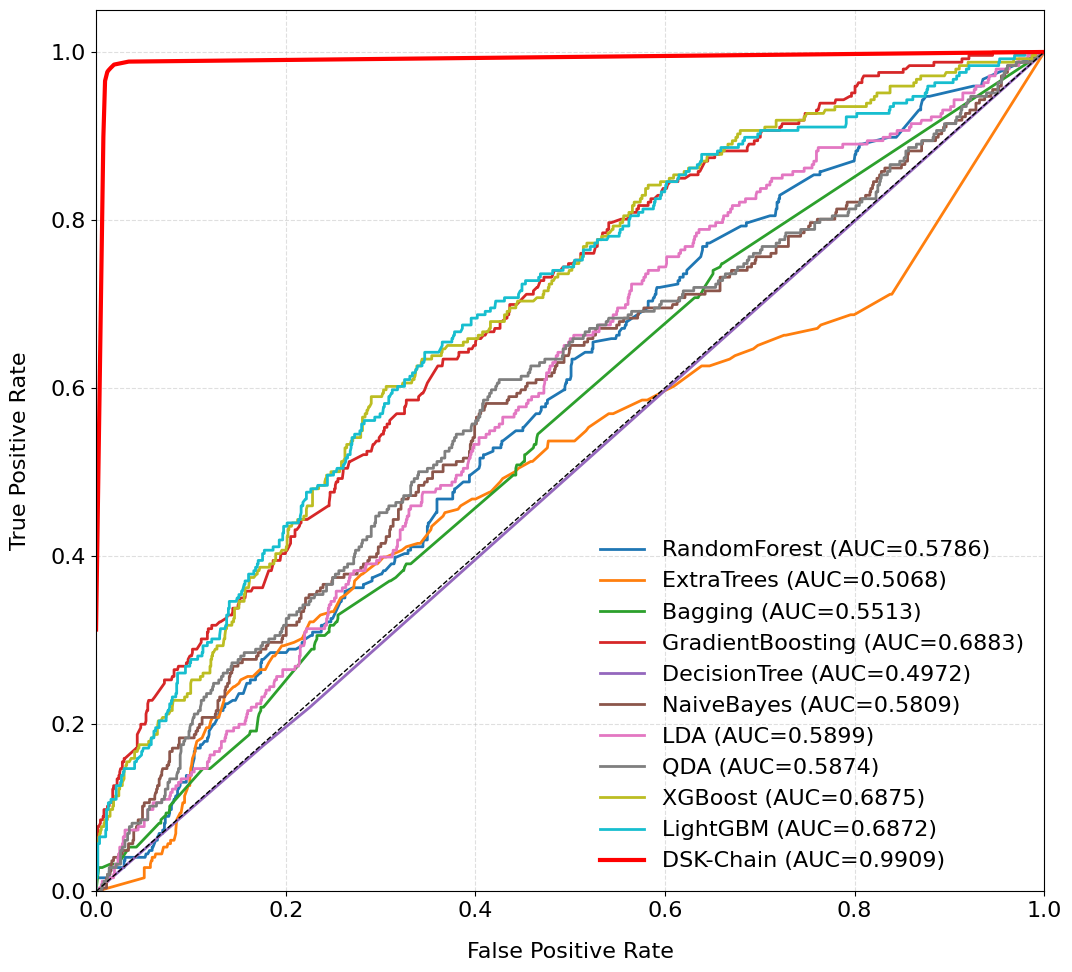

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(11, 10))

# binary models
for r in binary_rocs:
    plt.plot(r['fpr'], r['tpr'], lw=2, label=f"{r['name']} (AUC={r['auc']:.4f})")

# stacking model (macro-avg)
plt.plot(stacking_result['fpr'], stacking_result['tpr'], lw=3, color='red',
         label=f"{stacking_result['name']} (AUC={stacking_result['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', labelpad=15)
plt.ylabel('True Positive Rate', labelpad=15)
plt.legend(loc='lower right', fontsize=16, frameon=False)
plt.grid(linestyle='--', alpha=0.4)
plt.tight_layout()

plt.savefig("roc_curves.pdf", format="pdf", dpi=1000, bbox_inches="tight")
plt.savefig("roc_curves.efs", format="png", dpi=1000, bbox_inches="tight")


plt.show()
